In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cmaps
import cartopy.feature as cfeature
from datetime import datetime,timedelta
from matplotlib.offsetbox import AnchoredText#关于修改text位置的
from tqdm import tqdm
from skimage.feature import peak_local_max#寻找矩阵局部极值点
# 用于提取点集凹边界
import alphashape
#计算任意地球上多边形面积
from area import area
import os
import psutil
from sklearn.neighbors import BallTree
from utiles import *
proj =ccrs.NorthPolarStereo(central_longitude=15)
import ast
import calendar
import json
import concurrent.futures


In [2]:
#vort_min_line：word里的谷值线
#original_vort_line：word里的unpartitioned vortex border
#isolated_area_path：word里的所有孤立涡旋区域以外的涡旋区域被分配给涡旋后，涡旋的新边界

In [2]:
#提取某个小时的涡旋
def main_process(vort,u,v,parameter_sets,keeped_points=[]):
    #提取峰值和对应vort_min(谷值)线----------------------------------------------------------
    all_main_leafs,_,original_lines,_ = distinguish_peaks(vort,parameter_sets,keeped_points)
    chosed_time = vort.time
    if all_main_leafs is None:
        return None
    lons,lats= vort.longitude,vort.latitude
    lon_grid,lat_grid = np.meshgrid(lons,lats,indexing = 'xy')
    lon_lat_points = np.vstack([lon_grid.reshape(-1),lat_grid.reshape(-1)]).T
    #进一步处理总边界（unpartitioned vortex border）-------------------------------------------------------------
    unique_original_vort_line = all_main_leafs.original_vort_line.unique()
    new_vorts = []
    #对每一个总边界
    for i in range(len(unique_original_vort_line)):
        chosed_original_vort_line = unique_original_vort_line[i]
        temp_vort = all_main_leafs.loc[all_main_leafs.original_vort_line==chosed_original_vort_line].copy()
        new_vorts.append(area_deal(temp_vort,chosed_original_vort_line,lon_lat_points))
    new_main_leafs = pd.concat(new_vorts,axis = 0)
    #对错误original_lines的峰值进行校正（这种情况一般是靠近边界）
    error_borders_bools = np.isin(new_main_leafs.original_vort_line,original_lines.loc[original_lines.error_border,'line_path'])
    new_main_leafs.loc[ error_borders_bools,'isolated_area_path'] = new_main_leafs.loc[ error_borders_bools,'vort_min_line'] 
    #计算实际面积--------------------------------------------------------------
    record_line_area_r = []
    for isolated_area_path in new_main_leafs.isolated_area_path.values:
        line_area  = area({'type':'Polygon','coordinates':[isolated_area_path.vertices.tolist()]})/1e6########   闭环,平方公里[(纬度，经度)]
        line_area_r = np.sqrt(line_area/np.pi)#涡旋的半径是由相同面积的圆的的半径
        record_line_area_r.append(line_area_r)
    new_main_leafs['r'] = record_line_area_r
    #融合风场，预测下一时间步位置------------------------------------------------
    #边界的等值线可能会出问题，表现在new_main_leafs的峰值被重复计算，index多次出现，不知道怎么解决，简单的去除
    if len(new_main_leafs.index)>len(np.unique(new_main_leafs.index)):
        correct = [np.sum(new_main_leafs.index==index)==1 for index in new_main_leafs.index] 
        new_main_leafs = new_main_leafs.loc[correct]
    isolated_peaks = wind_merge(u,v,[500,600,700,850,925],new_main_leafs,lons,lats).infer_objects()
    isolated_peaks['time'] = chosed_time.values
    isolated_peaks.insert(0, 'time', isolated_peaks.pop('time'))
    return isolated_peaks

In [3]:
#连续时间的涡旋连接,我这里是提取某小时后的涡旋后直接连接的,也可以先提取所有时间的再连接
#running_record：还未消逝的涡旋轨迹
def vort_match(case_file_pressure,running_record,parameter_sets,desc):
    case_file_vort = case_file_pressure.vo.loc[:,850]*1e4
    case_file_u,case_file_v = case_file_pressure.u,case_file_pressure.v
    del case_file_pressure
    closed_record= []
    #tqdm的初始化，我们可以直接用with语句来管理它
    for index in tqdm(range(len(case_file_vort)),desc=desc):
        isolated_peaks_next = main_process(case_file_vort[index],case_file_u[index],case_file_v[index],parameter_sets)
        if isolated_peaks_next is None:
            closed_record+=running_record
            running_record = []
            continue
        running_record, closed_record = track_vort(running_record, closed_record, isolated_peaks_next)
    return closed_record,running_record

一些全局参数设置

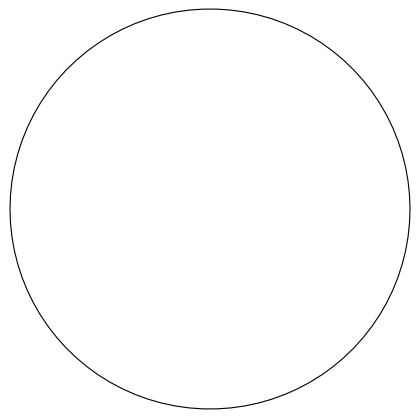

In [4]:
smooth_r = 60#km,平滑半径设置
vort_max0 = 1.2#相对涡度极值限制
vort_min0 = 1#相对涡度区域极值限制
scal_factor = 0.15#缩放因子，用来判断邻接的涡度极大值是否为孤立涡旋
#随便创建一个坐标区，需要这个坐标区画等值线
proj =ccrs.NorthPolarStereo(central_longitude=15)
#proj = ccrs.LambertConformal(central_longitude=15)
fig = plt.figure(figsize=(12,8))
useless_ax = fig.add_axes([0.1, 0.1, 0.5, 0.5],projection = proj)
parameter_sets = [smooth_r,vort_max0,useless_ax,vort_min0,scal_factor] 

读取数据

In [5]:
chosed_year,chosed_month = 2008,11
nc_file = xr.open_dataset(r"Z:\ERA5_data\pressures\2008_11_pressures.nc")
desc = "%d年%d月"%(chosed_year,chosed_month)
closed_record,running_record = vort_match(nc_file,[],parameter_sets,desc)
all_record = closed_record+running_record
#整理
path_collections = []
#每月记录已结束的
for i in tqdm(range(len(all_record))): 
    temp = pd.concat(all_record[i].return_all_node(),axis=1).T.copy()
    temp = temp.reset_index(drop=True)
    temp['path_index'] = i
    path_collections.append(temp)
ERA5_tracks = pd.concat(path_collections,axis=0).reset_index().drop(['index','vort_min'],axis=1)
ERA5_tracks.insert(1, 'path_index', ERA5_tracks.pop('path_index'))
ERA5_tracks[['lat','lon']] = ERA5_tracks.loc[:,['lat','lon']].values.astype('float')
#
ERA5_tracks.isolated_area_path = ERA5_tracks.isolated_area_path.apply(lambda x:json.dumps(np.round(x.vertices,3).tolist()))
ERA5_tracks.vort_min_line = ERA5_tracks.vort_min_line.apply(lambda x:json.dumps(np.round(x.vertices,3).tolist()))
ERA5_tracks.original_vort_line = ERA5_tracks.original_vort_line.apply(lambda x:json.dumps(np.array(np.round(x.vertices,3)).tolist()))
ERA5_tracks.to_excel(r'D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\track_2008_11.xlsx')

d:\anaconda\envs\FRZ\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
100%|██████████| 942/942 [00:00<00:00, 1404.38it/s]


In [6]:
ERA5_tracks

,time,path_index,lon,lat,peak_value,vort_min_line,original_vort_line,isolated_num,isolated_area_path,r,steer_u,steer_v,next_lon,next_lat
0,2008-11-01 00:00:00,0,-18.25,72.25,1.576954,"[[-20.5, 72.621], [-20.25, 72.654], [-20.0, 72...","[[-14.663, 85.0], [-14.5, 84.886], [-14.318, 8...",6,"[[-19.0, 72.0], [-19.25, 72.0], [-19.5, 72.0],...",54.040877,9.355544,-0.561941,-17.258075,72.231827
1,2008-11-01 00:00:00,1,-0.50,77.00,1.815238,"[[-2.75, 79.797], [-2.5, 79.839], [-2.25, 79.8...","[[-14.663, 85.0], [-14.5, 84.886], [-14.318, 8...",6,"[[4.75, 78.25], [5.0, 78.0], [5.25, 78.0], [5....",192.015978,6.578094,4.344186,0.450737,77.140488
2,2008-11-01 00:00:00,2,-30.25,66.00,2.566751,"[[-30.5, 66.741], [-30.25, 66.715], [-30.0, 66...","[[-15.25, 70.506], [-15.0, 70.523], [-14.75, 7...",5,"[[-28.0, 66.75], [-27.75, 66.75], [-27.5, 66.7...",82.700323,19.887358,-3.538622,-28.672305,65.885563
3,2008-11-01 00:00:00,3,27.00,64.50,1.591397,"[[27.5, 65.004], [27.75, 65.009], [28.0, 65.03...","[[44.25, 66.252], [44.5, 66.252], [44.598, 66....",4,"[[31.0, 64.5], [30.75, 64.5], [30.5, 64.5], [3...",137.344599,0.239958,-0.21808,27.018023,64.492947
4,2008-11-01 00:00:00,4,-9.50,72.50,1.675173,"[[6.5, 76.014], [6.75, 76.021], [7.0, 76.01], ...","[[-14.663, 85.0], [-14.5, 84.886], [-14.318, 8...",6,"[[-0.5, 73.5], [-0.75, 73.5], [-1.0, 73.25], [...",162.536296,14.982186,5.013935,-7.881467,72.662147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,2008-11-30 23:00:00,938,29.25,66.75,1.307585,"[[30.0, 67.504], [30.25, 67.548], [30.5, 67.56...","[[30.0, 67.504], [30.25, 67.548], [30.5, 67.56...",1,"[[30.0, 67.504], [30.25, 67.548], [30.5, 67.56...",75.482875,6.843717,12.383246,29.815286,67.150466
10150,2008-11-30 22:00:00,939,46.25,60.75,1.31329,"[[45.75, 62.165], [46.0, 62.043], [46.024, 62....","[[45.75, 62.165], [46.0, 62.043], [46.024, 62....",1,"[[45.75, 62.165], [46.0, 62.043], [46.024, 62....",84.95404,9.183723,6.938838,46.859961,60.974398
10151,2008-11-30 23:00:00,939,46.75,60.50,1.32005,"[[46.5, 62.023], [46.523, 62.0], [46.75, 61.84...","[[46.5, 62.023], [46.523, 62.0], [46.75, 61.84...",1,"[[46.5, 62.023], [46.523, 62.0], [46.75, 61.84...",83.771438,9.226174,6.709297,47.357957,60.716974
10152,2008-11-30 23:00:00,940,-15.75,65.75,1.524033,"[[-19.5, 67.813], [-19.25, 67.887], [-19.0, 67...","[[-19.5, 67.813], [-19.25, 67.887], [-19.0, 67...",1,"[[-19.5, 67.813], [-19.25, 67.887], [-19.0, 67...",100.363561,9.558558,-7.115417,-15.000708,65.519892
